In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, clear_output
import pandas as pd

pd.set_option('display.max_columns', 500)

In [7]:
outdir= './output/DaughterAnalysis/'
inputdir = './input/'  

nu_file = inputdir+'NueCC_nu_mcc9_nov.root'
nue_file = inputdir+'NueCC_nue_mcc9_nov.root'

In [8]:
lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]
fidvol_vtx = [10,10,10,10,10,50] 
fidvol_end = [10,10,10,10,10,10]

In [9]:
def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return mask

In [10]:
nu_daughters = uproot.open(nu_file)['nueCCAnalyser/Daughters'].pandas.df()
nue_daughters = uproot.open(nue_file)['nueCCAnalyser/Daughters'].pandas.df()

In [11]:
daughters = pd.concat([nu_daughters,nue_daughters])

In [12]:
# Add reco containment
start_mask = inTPC_df(daughters, 'vx', 'vy', 'vz', fidvol_vtx)
end_mask = inTPC_df(daughters, 'track_endx', 'track_endy', 'track_endz', fidvol_vtx)
daughters['contained'] = start_mask & end_mask 

# Add theta angle
v1_u = daughters[['track_dirx','track_diry','track_dirz']]
v2_u = [0,0,1]
daughters['track_theta'] = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
v3_u = [0,-1,0]
daughters['track_zenith'] = np.arccos(np.clip(np.dot(v1_u, v3_u), -1.0, 1.0))

# Add true fidvol
daughters['mc_fidvol'] = inTPC_df(daughters, 'mc_vx', 'mc_vy', 'mc_vz', fidvol_vtx)

# Add distance from true to reco vertex: 
eval_str = "sqrt( (vx-mc_vx_sce)**2 + (vy-mc_vy_sce)**2 + (vz-mc_vz_sce)**2 )"
daughters['mc_reco_vtx_distance'] = daughters.eval(eval_str)

# Add categories to train/test on
good_str = "mc_neutrino & mc_fidvol & "
cat_e_good = good_str+"abs(mc_pdg)==11"
cat_p_good = good_str+"abs(mc_pdg)==2212"
cat_g_good = good_str+"mc_pdg==22"
cat_mu_good = good_str+"abs(mc_pdg)==13"
cat_pi_good = good_str+"abs(mc_pdg)==211"
cat_cosmic = "~mc_neutrino"

daughters['category'] =  1*daughters.eval(cat_e_good)+\
                         2*daughters.eval(cat_p_good)+\
                         3*daughters.eval(cat_g_good)+\
                         4*daughters.eval(cat_mu_good)+\
                         5*daughters.eval(cat_pi_good)+\
                         6*daughters.eval(cat_cosmic)

target_names = ['other','electron', 'proton', 'photon', 'nu muon', 'charged pion', 'cosmic']
label_map = dict(zip(range(7),target_names))
daughters['label'] = daughters['category'].map(label_map)

In [13]:
daughters.columns

Index(['event', 'run', 'subrun', 'evt_time_sec', 'evt_time_nsec', 'hitsU',
       'hitsV', 'hitsY', 'caloU', 'caloV', 'caloY', 'hitsSps', 'generation',
       'track_score', 'is_shower', 'is_track', 'has_shower_daughter',
       'is_track_daughter', 'vx', 'vy', 'vz', 'vtx_distance', 'track_length',
       'track_endx', 'track_endy', 'track_endz', 'track_dirx', 'track_diry',
       'track_dirz', 'shower_length', 'shower_openangle', 'shower_dirx',
       'shower_diry', 'shower_dirz', 'start_dedxU', 'start_dedxV',
       'start_dedxY', 'start_hitsU', 'start_hitsV', 'start_hitsY',
       'start_pitchU', 'start_pitchV', 'start_pitchY', 'mc_neutrino', 'mc_vx',
       'mc_vy', 'mc_vz', 'mc_vx_sce', 'mc_vy_sce', 'mc_vz_sce', 'mc_energy',
       'mc_pdg', 'contained', 'track_theta', 'track_zenith', 'mc_fidvol',
       'mc_reco_vtx_distance', 'category', 'label'],
      dtype='object')

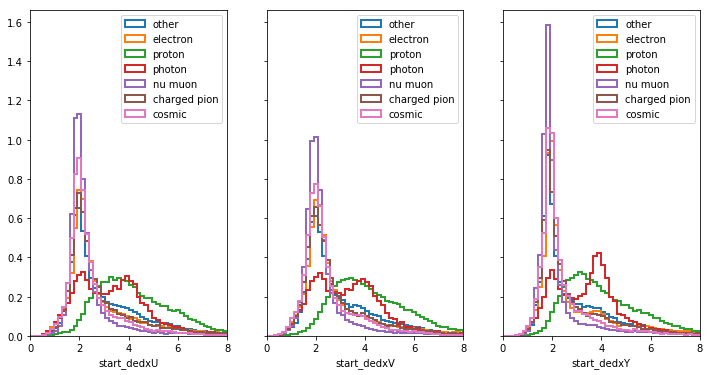

In [14]:
fig,ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,6))

xmin=0
xmax=8

for i,plane in enumerate(["U","V","Y"]):
    for name in target_names:
        str_query = "start_hits"+plane+">3 & abs(start_pitch"+plane+")<0.9 & label==@name"
        field = "start_dedx"+plane
        data= daughters.query(str_query)[field]
        ax[i].hist(data, bins=50, range=(xmin,xmax), label=name, histtype='step',lw=2, density=True)
    ax[i].set_xlabel(field)
    ax[i].set_xlim(xmin,xmax)
    ax[i].legend()

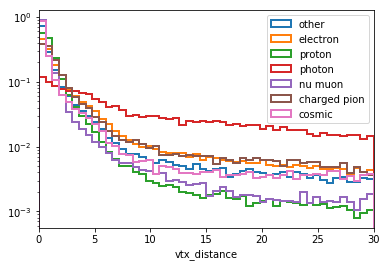

In [15]:
fig,ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6,4))

xmin=0
xmax=30

for name in target_names:
    field = "vtx_distance"
    data = daughters.query("label==@name")[field]
    ax.hist(data, bins=50, range=(xmin,xmax), label=name, histtype='step',lw=2, density=True)
ax.set_xlabel(field)
ax.set_xlim(xmin,xmax)
ax.set_yscale('log')
ax.legend()